# Лабораторная работа №8

|Выполнил студент группы|ФИО|Вариант|
|--|--|--|
|М8О-406Б-19|Илья Ильин Олегович|1|
### Задание

Используя схемы переменных направлений и дробных шагов, решить двумерную
начально-краевую задачу для дифференциального уравнения параболического типа

В различные моменты времени вычислить
погрешность численного решения путем сравнения результатов с приведенным в
задании аналитическим решением
$U(x,t)$
. Исследовать зависимость погрешности от
сеточных параметров
$ \tau, h_x, h_y$ .

### Вариант

**Уравнение:**

$\frac{\partial u}{\partial t} = a \frac{\partial^2 u}{\partial x^2} + a \frac{\partial^2 u}{\partial y^2}, a > 0$

**Граничные условия:**

$u(0, y, t) = cos(\mu_2 y)exp(-(\mu_1^2 + \mu_2^2)at)$

$u(\frac{\pi}{2}\mu_1, y, t) = 0$

$u(x, 0, t) = cos(\mu_1 x)exp(-(\mu_1^2 + \mu_2^2)at)$

$u(x, \frac{\pi}{2}\mu_2, t) = 0$

$u(x, y, 0) = cos(\mu_1x)cos(\mu_2y)$

**Аналитическое решение:**

$U(x, y, y) = cos(\mu_1x)cos(\mu_2y)exp(-(\mu_1^2 + \mu_2^2)at)$

**Значения параметров:**

1) $\mu_1 = 1, \mu_2 = 1$
2) $\mu_1 = 2, \mu_2 = 1$
3) $\mu_1 = 1, \mu_2 = 2$


In [157]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
from typing import List, Callable
from functools import partial

import copy

In [158]:
def sweep_solve(matrix: np.ndarray, target: np.ndarray) -> np.ndarray:
    p_coeffs: np.ndarray = np.zeros(shape=matrix.shape[1])
    q_coeffs: np.ndarray = np.zeros(shape=matrix.shape[1])

    for i in range(matrix.shape[1]):
        if i == matrix.shape[1] - 1:
            p_coeffs[i] = 0
        elif i == 0:
            p_coeffs[i] = -matrix[i, i + 1] / matrix[i, i]
        else:
            p_coeffs[i] = -matrix[i, i + 1] / (matrix[i, i] + matrix[i, i - 1] * p_coeffs[i - 1])

        if i == 0:
            q_coeffs[i] = target[i] / matrix[i, i]
        else:
            q_coeffs[i] = ((target[i] - matrix[i, i - 1] * q_coeffs[i - 1]) /
                           (matrix[i, i] + matrix[i, i - 1] * p_coeffs[i - 1]))

    answer: np.ndarray = np.zeros(shape=matrix.shape[1] + 1)

    for i in range(matrix.shape[1] - 1, -1, -1):
        answer[i] = p_coeffs[i] * answer[i + 1] + q_coeffs[i]

    return answer[:-1]

In [159]:
def common_algo(u_yt_initial_0: Callable, u_yt_initial_1: Callable,
                u_xt_initial_0: Callable, u_xt_initial_1: Callable,
                u_xy_initial_0,
                a: float, hx: float, hy: float, tau: float,
                lx: float, rx: float,
                ly: float, ry: float,
                t_bound: float,
                coef: float) -> np.ndarray:
    x: np.ndarray = np.arange(lx, rx + hx / 2.0, step=hx)
    y: np.ndarray = np.arange(ly, ry + hy / 2.0, step=hy)
    t: np.ndarray = np.arange(0, t_bound + tau / 4.0, step=tau / 2.0)
    u: np.ndarray = np.zeros(shape=(len(t), len(y), len(x)))

    for i, yi in enumerate(y):
        for j, xj in enumerate(x):
            u[0, i, j] = u_xy_initial_0(xj, yi)
    for i, ti in enumerate(t):
        for j, yj in enumerate(y):
            u[i, j, 0] = u_yt_initial_0(yj, ti, a=a)
            u[i, j, -1] = u_yt_initial_1(yj, ti)
    for i, ti in enumerate(t):
        for j, xj in enumerate(x):
            u[i, 0, j] = u_xt_initial_0(xj, ti, a=a)
            u[i, -1, j] = u_xt_initial_1(xj, ti)

    for k in range(0, len(t) - 2, 2):
        for i in range(1, len(y) - 1):
            matrix: np.ndarray = np.zeros(shape=(len(x) - 2, len(x) - 2))
            matrix[0] += np.array(
                [
                    -(2.0 * a * tau * hy**2 + (1.0 + coef) * hx**2 * hy**2),
                    a * tau * hy**2
                ]
                + [0.0] * (len(matrix) - 2)
            )
            target: List[float] = [-a * tau * hx**2 * coef * u[k, i-1, 1] -
                                   ((1.0 + coef) * hx**2 * hy**2 - 2.0 * a * tau * hx**2 * coef) * u[k, i, 1] -
                                   a * tau * hx**2 * coef * u[k, i+1, 1] -
                                   a * tau * hy**2 * u[k+1, i, 0]]

            for j in range(1, len(matrix) - 1):
                matrix[j] += np.array(
                    [0.0] * (j - 1)
                    + [
                        a * tau * hy**2,
                        -(2.0 * a * tau * hy**2 + (1.0 + coef) * hx**2 * hy**2),
                        a * tau * hy**2
                    ]
                    + [0.0] * (len(matrix) - j - 2)
                )
                target += [-a * tau * hx**2 * coef * u[k, i-1, j+1] -
                           ((1.0 + coef) * hx**2 * hy**2 - 2.0 * a * tau * hx**2 * coef) * u[k, i, j+1] -
                           a * tau * hx**2 * coef * u[k, i+1, j+1]]

            matrix[-1] += np.array(
                [0.0] * (len(matrix) - 2)
                + [
                    a * tau * hy ** 2,
                    -(2.0 * a * tau * hy**2 + (1.0 + coef) * hx**2 * hy**2)
                ]
            )
            target += [-a * tau * hx**2 * coef * u[k, i-1, -2] -
                       ((1.0 + coef) * hx**2 * hy**2 - 2.0 * a * tau * hx**2 * coef) * u[k, i, -2] -
                       a * tau * hx**2 * coef * u[k, i+1, -2] -
                       a * tau * hy**2 * u[k+1, i, -1]]

            u[k+1, i] += np.array([0.0] + sweep_solve(matrix, np.array(target)).tolist() + [0.0])

        for j in range(1, len(x) - 1):
            matrix: np.ndarray = np.zeros(shape=(len(y) - 2, len(y) - 2))
            matrix[0] += np.array(
                [
                    -(2.0 * a * tau * hx ** 2 + (1.0 + coef) * hx ** 2 * hy ** 2),
                    a * tau * hx ** 2
                ]
                + [0.0] * (len(matrix) - 2)
            )
            target: List[float] = [-a * tau * hy ** 2 * coef * u[k+1, 1, j-1] -
                                   ((1.0 + coef) * hx ** 2 * hy ** 2 - 2.0 * a * tau * hy ** 2 * coef) * u[k+1, 1, j] -
                                   a * tau * hy ** 2 * coef * u[k+1, 1, j+1] -
                                   a * tau * hx ** 2 * u[k+2, 0, j]]

            for i in range(1, len(matrix) - 1):
                matrix[i] += np.array(
                    [0.0] * (i - 1)
                    + [
                        a * tau * hx ** 2,
                        -(2.0 * a * tau * hx**2 + (1.0 + coef) * hx**2 * hy**2),
                        a * tau * hx ** 2
                    ]
                    + [0.0] * (len(matrix) - i - 2)
                )
                target += [-a * tau * hy ** 2 * coef * u[k+1, i+1, j-1] -
                           ((1.0 + coef) * hx**2 * hy**2 - 2.0 * a * tau * hy**2 * coef) * u[k+1, i+1, j] -
                           a * tau * hy**2 * coef * u[k+1, i+1, j+1]]

            matrix[-1] += np.array(
                [0.0] * (len(matrix) - 2)
                + [
                    a * tau * hx ** 2,
                    -(2.0 * a * tau * hx**2 + (1.0 + coef) * hx ** 2 * hy ** 2)
                ]
            )
            target += [-a * tau * hy ** 2 * coef * u[k+1, -2, j-1] -
                       ((1.0 + coef) * hx ** 2 * hy ** 2 - 2.0 * a * tau * hy ** 2 * coef) * u[k+1, -2, j] -
                       a * tau * hy ** 2 * coef * u[k+1, -2, j+1] -
                       a * tau * hx ** 2 * u[k+2, -1, j]]

            u[k+2, :, j] += np.array([0.0] + sweep_solve(matrix, np.array(target)).tolist() + [0.0])

    return u[::2]


def fractional_steps_method(u_yt_initial_0: Callable, u_yt_initial_1: Callable,
                            u_xt_initial_0: Callable, u_xt_initial_1: Callable,
                            u_xy_initial_0,
                            a: float, hx: float, hy: float, tau: float,
                            lx: float, rx: float,
                            ly: float, ry: float,
                            t_bound: float) -> np.ndarray:
    return common_algo(coef=0.0, **locals())


def alternating_directions_methods(u_yt_initial_0: Callable, u_yt_initial_1: Callable,
                                   u_xt_initial_0: Callable, u_xt_initial_1: Callable,
                                   u_xy_initial_0,
                                   a: float, hx: float, hy: float, tau: float,
                                   lx: float, rx: float,
                                   ly: float, ry: float,
                                   t_bound: float) -> np.ndarray:
    return common_algo(coef=1.0, **locals())

In [160]:
def analytical_solution(a: float,
                        x: float, y: float,
                        t: float,
                        mu1: float, mu2: float) -> float:
    return np.cos(mu1 * x) * np.cos(mu2 * y) * np.exp(-(mu1**2 + mu2**2) * a * t)


def analytical_grid(a: float, x: np.ndarray, y: np.ndarray, t: np.ndarray,
                    afunc: Callable) -> np.ndarray:
    grid: np.ndarray = np.zeros(shape=(len(t), len(y), len(x)))
    for i in range(len(t)):
        for j in range(len(y)):
            for k in range(len(x)):
                grid[i, j, k] = afunc(a, x[k], y[j], t[i])
    return grid


@np.vectorize
def u_yt_initial_0(y: float, t: float,
                   mu1: float, mu2: float, a: float) -> float:
    return np.cos(mu2 * y) * np.exp(-(mu1**2 + mu2**2) * a * t)


@np.vectorize
def u_yt_initial_1(y: float, t: float,
                   mu1: float, mu2: float) -> float:
    return 0.0


@np.vectorize
def u_xt_initial_0(x: float, t: float,
                   mu1: float, mu2: float, a: float) -> float:
    return np.cos(mu1 * x) * np.exp(-(mu1**2 + mu2**2) * a * t)


@np.vectorize
def u_xt_initial_1(x: float, t: float,
                   mu1: float, mu2: float) -> float:
    return 0.0


@np.vectorize
def u_xy_initial_0(x: float, y: float,
                   mu1: float, mu2: float) -> float:
    return np.cos(mu1 * x) * np.cos(mu2 * y)


def error(numeric: np.ndarray, analytical: np.ndarray) -> np.ndarray:
    return np.max(np.abs(numeric - analytical), axis=0)


def draw(numerical1: np.ndarray, label1: str,
         numerical2: np.ndarray, label2: str,
         analytical: np.ndarray,
         x: np.ndarray, y: np.ndarray,
         t_points: List[int], t: np.ndarray):
    fig = plt.figure(figsize=plt.figaspect(0.7))
    xx, yy = np.meshgrid(x, y)

    for i, ti in enumerate(t_points):
        ax = fig.add_subplot(len(t_points), 3, len(t_points) * i + 1, projection='3d')
        plt.title(label1 + f', t = {t[ti]}')
        ax.set_xlabel('x', fontsize=10)
        ax.set_ylabel('y', fontsize=10)
        ax.set_zlabel(f'u[t={t[ti]}]', fontsize=10)
        ax.plot_surface(xx, yy, numerical1[ti], cmap=cm.coolwarm, linewidth=0, antialiased=True)

        ax = fig.add_subplot(len(t_points), 3, len(t_points) * i + 2, projection='3d')
        ax.set_xlabel('x', fontsize=10)
        ax.set_ylabel('y', fontsize=10)
        ax.set_zlabel(f'u[t={t[ti]}]', fontsize=10)
        plt.title(label2 + f', t = {t[ti]}')
        ax.plot_surface(xx, yy, numerical2[ti], cmap=cm.coolwarm, linewidth=0, antialiased=True)

        ax = fig.add_subplot(len(t_points), 3, len(t_points) * i + 3, projection='3d')
        ax.set_xlabel('x', fontsize=10)
        ax.set_ylabel('y', fontsize=10)
        ax.set_zlabel(f'u[t={t[ti]}]', fontsize=10)
        plt.title(f'analytic, t = {t[ti]}')
        ax.plot_surface(xx, yy, analytical[ti], cmap=cm.coolwarm, linewidth=0, antialiased=True)

    plt.show()


def drawerror(analytical, numerical, t, x, y):
    fig = plt.figure(figsize=plt.figaspect(1))
    # plt.title('Error')
    # print(analytical.shape, numerical.shape, t.shape)
    # ax = fig.add_subplot(1, 3, 1)
    # ax.plot(range(t.shape[0]), [np.max(np.abs(analytical-numerical)[i]) for i in range(t.shape[0])])
    # ax.set_xlabel('t')

    # ax = fig.add_subplot(1, 3, 2)
    # ax.plot(range(x.shape[0]), [np.max(np.abs(analytical-numerical)[:,:,i]) for i in range(x.shape[0])])
    # ax.set_xlabel('x')

    # ax = fig.add_subplot(1, 3, 3)
    # ax.plot(range(y.shape[0]), [np.max(np.abs(analytical-numerical)[:,i,:]) for i in range(y.shape[0])])
    # ax.set_xlabel('y')

    plt.plot(range(t.shape[0]), np.max(np.max(np.abs(numerical - analytical), axis=1), axis=1))
    plt.show()

def drawslices(ans, z_ans, y, x, t):
    nt = t.shape[0]
    nx = x.shape[0]
    ny = y.shape[0]
    plt.rcParams['figure.figsize'] = [15, 5]
    fig = plt.figure()
    # ax_3d = fig.add_subplot(1,3,1, projection='3d')
    # ax_3d.plot_wireframe(x, y, ans[nt//2])
    # ax_3d.plot_wireframe(x, y, z_ans[nt//2], color = 'r')
    axx = fig.add_subplot(1,2,1)
    axx.plot(y, ans[nt // 4][nx // 4])
    axx.plot(y, z_ans[nt // 4][nx // 4], '.b')
    # axx.plot(y, ans[5][nx // 4])
    # axx.plot(y, z_ans[5][nx // 4], '.b')
    axx.plot(y, ans[nt // 4 * 2][nx // 4 * 2], 'r')
    axx.plot(y, z_ans[nt // 4 * 2][nx // 4 * 2], '.r')
    axx.plot(y, ans[nt // 4 * 3][nx // 4 * 3], 'g')
    axx.plot(y, z_ans[nt // 4 * 3][nx // 4 * 3], '.g')
    plt.xlabel('y')
    axy = fig.add_subplot(1,2,2)

    axy.plot(x, ans[nt // 4][:, ny // 4])
    axy.plot(x, z_ans[nt // 4][:, ny // 4], '.b')
    axy.plot(x, ans[nt // 4 * 2][:, ny // 4 * 2], 'r')
    axy.plot(x, z_ans[nt // 4 * 2][:, ny // 4 * 2], '.r')
    axy.plot(x, ans[nt // 4 * 3][:, ny // 4 * 3], 'g')
    axy.plot(x, z_ans[nt // 4 * 3][:, ny // 4 * 3], '.g')
    plt.xlabel('x')


In [163]:
def runner(a, hx, hy, tau, t_bound):

    mu = [(1.0, 1.0),
    (2.0, 1.0), 
    (1.0, 2.0)
    ]
    i = 0

    for mu1, mu2 in mu:
        print(f"----- TESTCASE {i} mu1 = {mu1}, mu2 = {mu2} ----\n")
        x: np.ndarray = np.arange(0, mu1 * np.pi / 2.0 + hx / 2.0, step=hx)
        y: np.ndarray = np.arange(0, mu2 * np.pi / 2.0 + hy / 2.0, step=hy)
        t: np.ndarray = np.arange(0, t_bound + tau, step=tau)

        kwargs = {
            "u_yt_initial_0": partial(u_yt_initial_0, mu1=mu1, mu2=mu2),
            "u_yt_initial_1": partial(u_yt_initial_1, mu1=mu1, mu2=mu2),
            "u_xt_initial_0": partial(u_xt_initial_0, mu1=mu1, mu2=mu2),
            "u_xt_initial_1": partial(u_xt_initial_1, mu1=mu1, mu2=mu2),
            "u_xy_initial_0": partial(u_xy_initial_0, mu1=mu1, mu2=mu2),
            "a": a,
            "hx": hx,
            "hy": hy,
            "tau": tau,
            "lx": 0.0,
            "rx": mu1 * np.pi / 2.0,
            "ly": 0.0,
            "ry": mu2 * np.pi / 2.0,
            "t_bound": t_bound
        }

        analytical = analytical_grid(a, x, y, t, partial(analytical_solution,
                                                         mu1=mu1, mu2=mu2))

        print("---------------- FSM ----------------")
        sol1 = fractional_steps_method(**kwargs)
        # print(np.max(np.abs(analytical - sol1), axis=0)[0])
        # print(dumberror(analytical=analytical, numeric=sol1))
        # print(sol1[0])
        # drawslices(analytical, sol1, x, y, t)
        # drawerror(analytical, sol1, t, x, y)
        print(sol1.shape)
        print(analytical.shape)

        print("-------------------------------------\n")
        print("---------------- ADM ----------------")
        sol2 = alternating_directions_methods(**kwargs)
        drawerror(analytical, sol2, t, x, y)


        t_points = [0, len(t) // 2, len(t) - 1]
        draw(sol1, "FSM", sol2, "ADM", analytical, x, y, t_points, t)

        

        print("=====================================\n\n")
        i += 1

----- TESTCASE 0 mu1 = 1.0, mu2 = 1.0 ----

---------------- FSM ----------------
(501, 11, 11)
(501, 11, 11)
-------------------------------------

---------------- ADM ----------------


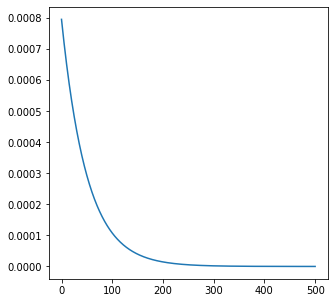

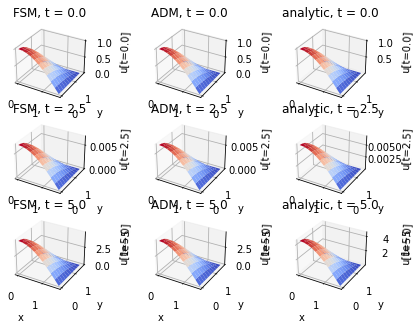



----- TESTCASE 1 mu1 = 2.0, mu2 = 1.0 ----

---------------- FSM ----------------
(501, 11, 21)
(501, 11, 21)
-------------------------------------

---------------- ADM ----------------


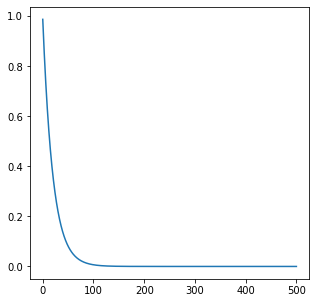

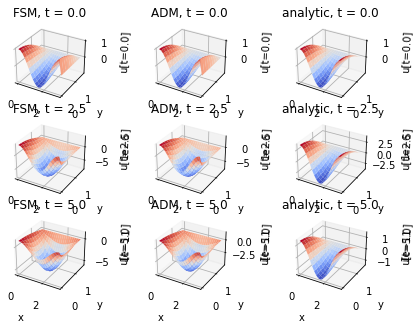



----- TESTCASE 2 mu1 = 1.0, mu2 = 2.0 ----

---------------- FSM ----------------
(501, 21, 11)
(501, 21, 11)
-------------------------------------

---------------- ADM ----------------


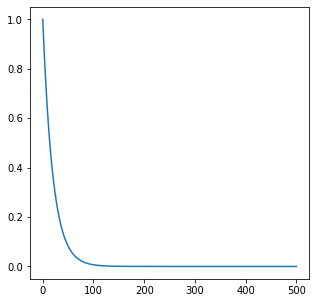

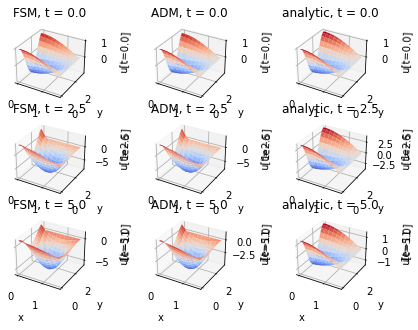

In [164]:
testcase = {
    'a': 1.0,
    'hx': 0.157,
    'hy': 0.157,
    'tau': 0.01,
    't_bound': 5.0   
}
runner(**testcase)

# 3 графика ошибки, по каждой оси x, y, t